# Seminário prático - Experimentos sobre meta-aprendizado

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from importlib import reload
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score

import aux
from aux import preprocess_default, ALL_ACC, ALL_ACC_SET, \
    drop_draw_set_class, drop_all_vs_rf, print_counter, \
    show_metrics, show_most_important_features
from itertools import combinations
from sklearn.metrics import precision_recall_fscore_support

from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv("meta-base.csv")
data

,general.attrToInst,general.catToNum,general.freqClass.mean,general.freqClass.sd,general.instToAttr,general.nrAttr,general.nrBin,general.nrCat,general.nrClass,general.nrInst,...,C4.5.auc,kNN.acc,kNN.f1m,kNN.auc,SVM.acc,SVM.f1m,SVM.auc,RF.acc,RF.f1m,RF.auc
0,0.100000,0.000000,0.5,0.471405,10.000000,60,0,0,2,600,...,0.993992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.042056,0.000000,0.5,0.204863,23.777778,9,0,0,2,214,...,0.786753,0.789214,0.764841,0.879050,0.770022,0.733372,0.835946,0.848485,0.822825,0.916196
2,0.121622,5.000000,0.5,0.066888,8.222222,18,9,15,2,148,...,0.813973,0.807071,0.803779,0.887428,0.846863,0.843160,0.927110,0.866887,0.861265,0.941109
3,0.492063,0.148148,0.5,0.145911,2.032258,31,0,4,2,63,...,0.662129,0.663429,0.680036,0.749489,0.761619,0.750802,0.827020,0.785238,0.771251,0.833724
4,0.020833,0.000000,0.5,0.105224,48.000000,7,2,0,2,336,...,0.959853,0.942531,0.941450,0.977326,0.966627,0.965831,0.985190,0.965199,0.964476,0.987683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.223881,0.071429,0.5,0.158307,4.466667,15,1,1,2,67,...,0.779784,0.768214,0.757795,0.843975,0.697202,0.701777,0.808815,0.798333,0.784645,0.858558
396,0.003472,0.000000,0.5,0.283170,288.000000,6,0,6,2,1728,...,0.982767,0.877835,0.844500,0.955360,0.957931,0.950636,0.993741,0.989701,0.987869,0.999346
397,0.021277,0.000000,0.5,0.342688,47.000000,18,0,0,2,846,...,0.969553,0.970795,0.962234,0.993139,0.979193,0.972641,0.996332,0.986998,0.982835,0.998817
398,0.023500,0.000000,0.5,0.565685,42.553191,47,0,0,2,2000,...,0.981546,0.993950,0.983220,0.998558,0.994550,0.984556,0.999174,0.988250,0.965376,0.998578


# Primeiro experimento - 5 Classes

In [4]:
#remove as colunas referentes às medidas f1m e auc
data.drop(data.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)
data.loc[:, ['landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'ANN.acc', 
             'C4.5.acc', 'kNN.acc', 'SVM.acc', 'RF.acc']]

,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,ANN.acc,C4.5.acc,kNN.acc,SVM.acc,RF.acc
0,0.038789,0.886667,0.041425,1.000000,0.992000,1.000000,1.000000,1.000000
1,0.089963,0.617662,0.076761,0.708379,0.784846,0.789214,0.770022,0.848485
2,0.123754,0.560536,0.119251,0.837292,0.792357,0.807071,0.846863,0.866887
3,0.160420,0.639048,0.171734,0.767238,0.646000,0.663429,0.761619,0.785238
4,0.110580,0.604069,0.075009,0.961919,0.949307,0.942531,0.966627,0.965199
...,...,...,...,...,...,...,...,...
395,0.160472,0.636310,0.179899,0.770893,0.765179,0.768214,0.697202,0.798333
396,0.018734,0.700249,0.018734,0.999768,0.950167,0.877835,0.957931,0.989701
397,0.041359,0.742169,0.042820,0.982605,0.962633,0.970795,0.979193,0.986998
398,0.008433,0.900000,0.000000,0.994850,0.983450,0.993950,0.994550,0.988250


In [5]:
#remove as amostras com empate (com relação à maior acurácia) e determina as classes
data = drop_draw_set_class(data.copy())
data.loc[:, ['landmarking.randomNode.mean', 'landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'Class']]

,landmarking.randomNode.mean,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,Class
0,0.655297,0.089963,0.617662,0.076761,RF.acc
1,0.593000,0.123754,0.560536,0.119251,RF.acc
2,0.569762,0.160420,0.639048,0.171734,RF.acc
3,0.674139,0.110580,0.604069,0.075009,SVM.acc
4,0.648228,0.142807,0.643772,0.147598,ANN.acc
...,...,...,...,...,...
378,0.676190,0.160472,0.636310,0.179899,RF.acc
379,0.700249,0.018734,0.700249,0.018734,ANN.acc
380,0.752254,0.041359,0.742169,0.042820,RF.acc
381,0.903000,0.008433,0.900000,0.000000,ANN.acc


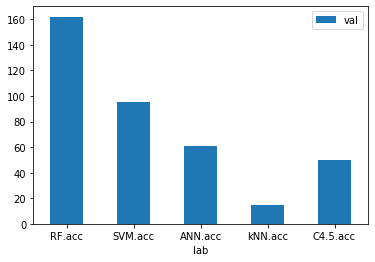

In [10]:
#plota distribuição das classes
X = data.drop('Class', axis=1)
y = data['Class']

vec = list(zip( *[*Counter( y ).items()])) 
gambs = pd.DataFrame(dict(zip(['lab', 'val'],vec))) 
ax = gambs.plot.bar(x='lab', y='val', rot=0) 
plt.show(block=True)

Fold  0  Id:  0
accuracy: 0.421875
precision:  0.084375
recall:  0.2
f1_score:  0.11868131868131868
precision_recall_fscore_support : 
	
	[0.       0.       0.421875 0.       0.      ]
	[0. 0. 1. 0. 0.]
	[0.         0.         0.59340659 0.         0.        ]
	[20 17 54 32  5]
Confusion matrix


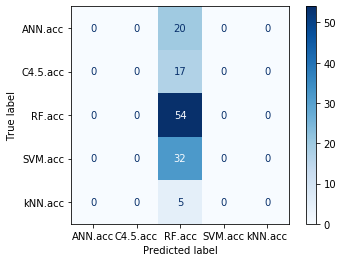


 

Fold  1  Id:  1
accuracy: 0.421875
precision:  0.084375
recall:  0.2
f1_score:  0.11868131868131868
precision_recall_fscore_support : 
	
	[0.       0.       0.421875 0.       0.      ]
	[0. 0. 1. 0. 0.]
	[0.         0.         0.59340659 0.         0.        ]
	[20 17 54 32  5]
Confusion matrix


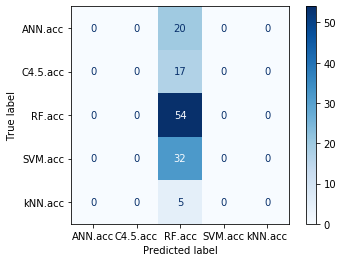


 

Fold  2  Id:  2
accuracy: 0.4251968503937008
precision:  0.08503937007874016
recall:  0.2
f1_score:  0.11933701657458562
precision_recall_fscore_support : 
	
	[0.         0.         0.42519685 0.         0.        ]
	[0. 0. 1. 0. 0.]
	[0.         0.         0.59668508 0.         0.        ]
	[21 16 54 31  5]
Confusion matrix


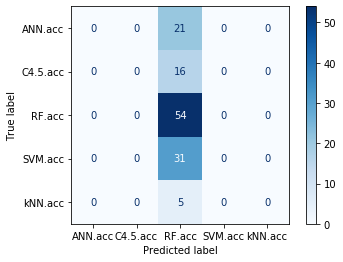


 

------------------------
Considered classes : All 

Mean accuracy =  0.0 



In [11]:
#aplicação do algoritmo Random Forest usando 3-folds cross validation seguido da avaliação das predições

rfc = RandomForestClassifier(n_estimators=200)
k = 0
acc = 0
acc_sum = 0   
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits)
features_list = []
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold ", k, " Id: ", iii)
    iii += 1
    rfc.fit(StandardScaler().fit_transform(X.loc[train_index, :].drop('index', axis=1)), y.loc[train_index])
    features_list.append(rfc.feature_importances_)
    y_pred = rfc.predict(X.loc[test_index, :].drop('index', axis=1), )
    
    show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    #matriz de confusão
    print("Confusion matrix")  
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :].drop('index', axis=1), y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    plt.show()
    print("\n \n")

#printa as médias das medidas tiradas nos 10 folds
print("------------------------")
print("Considered classes : All \n")
print("Mean accuracy = ", acc_sum / n_splits, "\n")

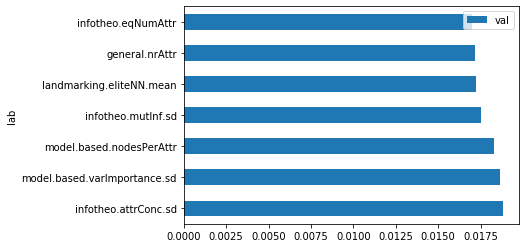

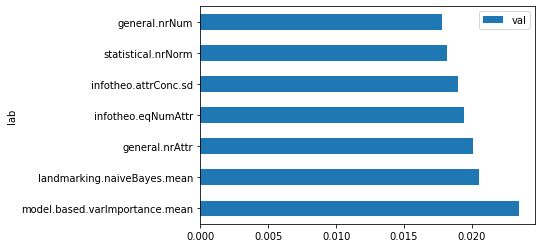

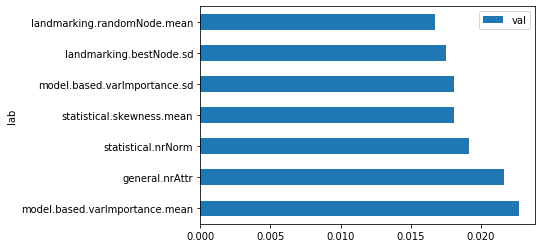

In [12]:
#exibe as características mais informativas da base em cada fold
show_most_important_features(X, features_list=features_list)

# Segundo experimento - Classes dois a dois

Considered classes
RF.acc -> 246
SVM.acc -> 151


Fold  0  Id:  0
accuracy: 0.47368421052631576
precision:  0.4849315068493151
recall:  0.4842180774748924
f1_score:  0.4712630622444343
precision_recall_fscore_support : 
	
	[0.6        0.36986301]
	[0.43902439 0.52941176]
	[0.50704225 0.43548387]
	[82 51]


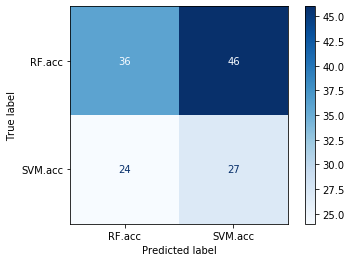


 

Fold  1  Id:  1
accuracy: 0.5757575757575758
precision:  0.5036284470246735
recall:  0.5024390243902439
f1_score:  0.48264277715565507
precision_recall_fscore_support : 
	
	[0.62264151 0.38461538]
	[0.80487805 0.2       ]
	[0.70212766 0.26315789]
	[82 50]


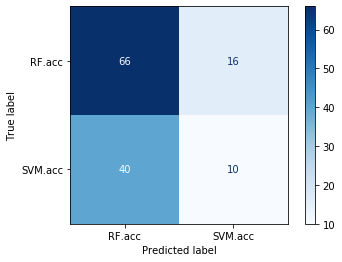


 

Fold  2  Id:  2
accuracy: 0.6212121212121212
precision:  0.3106060606060606
recall:  0.5
f1_score:  0.383177570093458
precision_recall_fscore_support : 
	
	[0.62121212 0.        ]
	[1. 0.]
	[0.76635514 0.        ]
	[82 50]


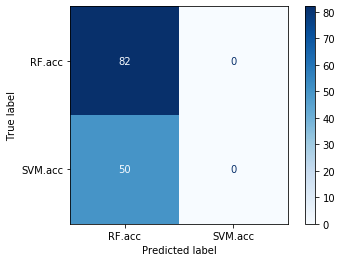


 

Mean accuracy =  0.5568846358320042 

-----------------------

Considered classes
RF.acc -> 304
C4.5.acc -> 89


Fold  0  Id:  3
accuracy: 0.7404580152671756
precision:  0.4585253456221198
recall:  0.48782961460446245
f1_score:  0.4525565388397247
precision_recall_fscore_support : 
	
	[0.14285714 0.77419355]
	[0.03448276 0.94117647]
	[0.05555556 0.84955752]
	[ 29 102]


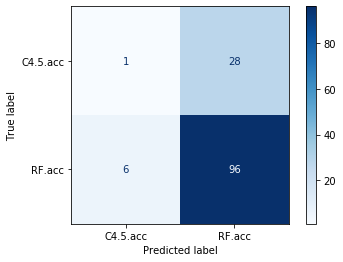


 

Fold  1  Id:  4
accuracy: 0.22900763358778625
precision:  0.11450381679389313
recall:  0.5
f1_score:  0.18633540372670807
precision_recall_fscore_support : 
	
	[0.22900763 0.        ]
	[1. 0.]
	[0.37267081 0.        ]
	[ 30 101]


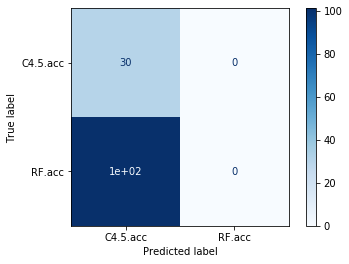


 

Fold  2  Id:  5
accuracy: 0.6717557251908397
precision:  0.5664174813110983
recall:  0.5762376237623763
f1_score:  0.5688480673555301
precision_recall_fscore_support : 
	
	[0.32432432 0.80851064]
	[0.4        0.75247525]
	[0.35820896 0.77948718]
	[ 30 101]


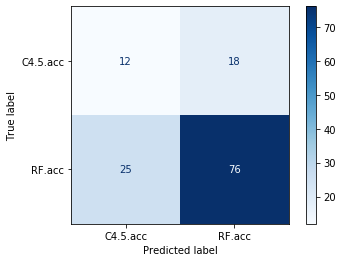


 

Mean accuracy =  0.5470737913486005 

-----------------------

Considered classes
SVM.acc -> 230
C4.5.acc -> 165


Fold  0  Id:  6
accuracy: 0.5833333333333334
precision:  0.2916666666666667
recall:  0.5
f1_score:  0.3684210526315789
precision_recall_fscore_support : 
	
	[0.         0.58333333]
	[0. 1.]
	[0.         0.73684211]
	[55 77]


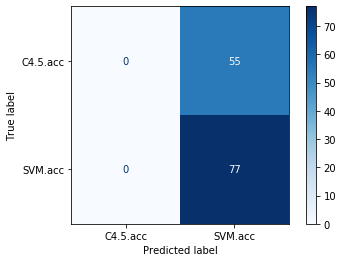


 

Fold  1  Id:  7
accuracy: 0.4166666666666667
precision:  0.20833333333333334
recall:  0.5
f1_score:  0.29411764705882354
precision_recall_fscore_support : 
	
	[0.41666667 0.        ]
	[1. 0.]
	[0.58823529 0.        ]
	[55 77]


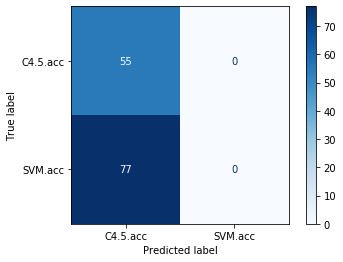


 

Fold  2  Id:  8
accuracy: 0.4198473282442748
precision:  0.2099236641221374
recall:  0.5
f1_score:  0.2956989247311828
precision_recall_fscore_support : 
	
	[0.41984733 0.        ]
	[1. 0.]
	[0.59139785 0.        ]
	[55 76]


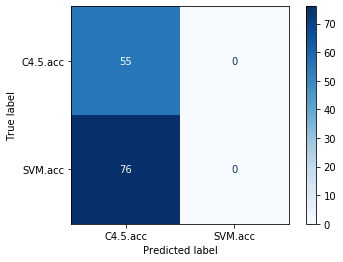


 

Mean accuracy =  0.47328244274809156 

-----------------------

Considered classes
RF.acc -> 347
kNN.acc -> 49


Fold  0  Id:  9
accuracy: 0.8636363636363636
precision:  0.43846153846153846
recall:  0.49137931034482757
f1_score:  0.46341463414634143
precision_recall_fscore_support : 
	
	[0.87692308 0.        ]
	[0.98275862 0.        ]
	[0.92682927 0.        ]
	[116  16]


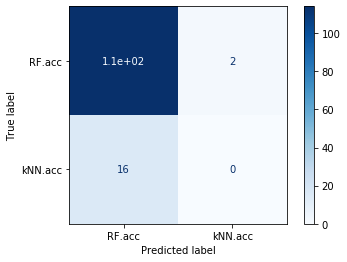


 

Fold  1  Id:  10
accuracy: 0.8787878787878788
precision:  0.4393939393939394
recall:  0.5
f1_score:  0.46774193548387094
precision_recall_fscore_support : 
	
	[0.87878788 0.        ]
	[1. 0.]
	[0.93548387 0.        ]
	[116  16]


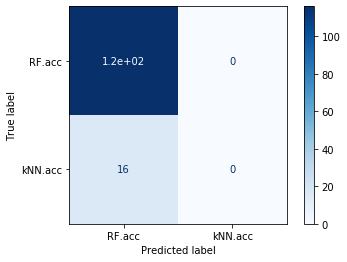


 

Fold  2  Id:  11
accuracy: 0.8712121212121212
precision:  0.4356060606060606
recall:  0.5
f1_score:  0.46558704453441296
precision_recall_fscore_support : 
	
	[0.87121212 0.        ]
	[1. 0.]
	[0.93117409 0.        ]
	[115  17]


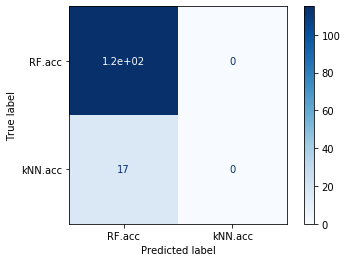


 

Mean accuracy =  0.8712121212121212 

-----------------------

Considered classes
kNN.acc -> 79
SVM.acc -> 317


Fold  0  Id:  12
accuracy: 0.7954545454545454
precision:  0.3977272727272727
recall:  0.5
f1_score:  0.4430379746835443
precision_recall_fscore_support : 
	
	[0.79545455 0.        ]
	[1. 0.]
	[0.88607595 0.        ]
	[105  27]


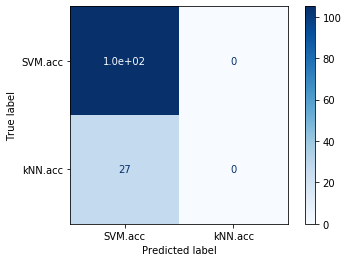


 

Fold  1  Id:  13
accuracy: 0.7348484848484849
precision:  0.3943089430894309
recall:  0.45754716981132076
f1_score:  0.4235807860262009
precision_recall_fscore_support : 
	
	[0.78861789 0.        ]
	[0.91509434 0.        ]
	[0.84716157 0.        ]
	[106  26]


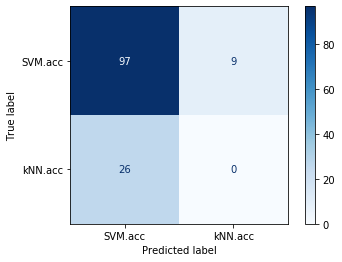


 

Fold  2  Id:  14
accuracy: 0.6818181818181818
precision:  0.5456182472989196
recall:  0.5551523947750363
f1_score:  0.5470588235294118
precision_recall_fscore_support : 
	
	[0.82653061 0.26470588]
	[0.76415094 0.34615385]
	[0.79411765 0.3       ]
	[106  26]


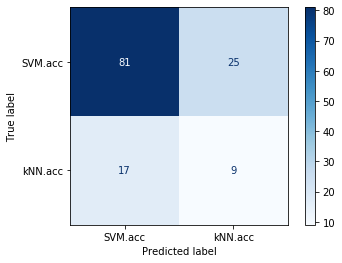


 

Mean accuracy =  0.7373737373737373 

-----------------------

Considered classes
kNN.acc -> 120
C4.5.acc -> 277


Fold  0  Id:  15
accuracy: 0.6090225563909775
precision:  0.5289473684210526
recall:  0.5280913978494624
f1_score:  0.5283687943262412
precision_recall_fscore_support : 
	
	[0.71578947 0.34210526]
	[0.7311828 0.325    ]
	[0.72340426 0.33333333]
	[93 40]


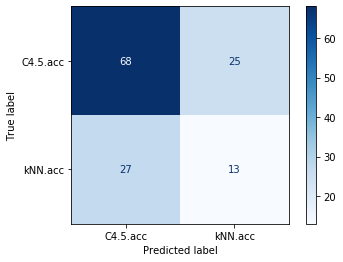


 

Fold  1  Id:  16
accuracy: 0.696969696969697
precision:  0.3484848484848485
recall:  0.5
f1_score:  0.41071428571428575
precision_recall_fscore_support : 
	
	[0.6969697 0.       ]
	[1. 0.]
	[0.82142857 0.        ]
	[92 40]


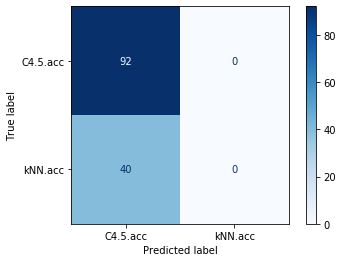


 

Fold  2  Id:  17
accuracy: 0.696969696969697
precision:  0.3484848484848485
recall:  0.5
f1_score:  0.41071428571428575
precision_recall_fscore_support : 
	
	[0.6969697 0.       ]
	[1. 0.]
	[0.82142857 0.        ]
	[92 40]


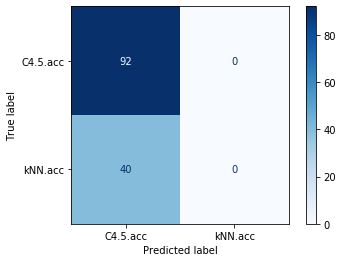


 

Mean accuracy =  0.6676539834434573 

-----------------------

Considered classes
RF.acc -> 271
ANN.acc -> 118


Fold  0  Id:  18
accuracy: 0.6461538461538462
precision:  0.43544690603514136
recall:  0.4761904761904762
f1_score:  0.4304761904761904
precision_recall_fscore_support : 
	
	[0.18181818 0.68907563]
	[0.05128205 0.9010989 ]
	[0.08       0.78095238]
	[39 91]


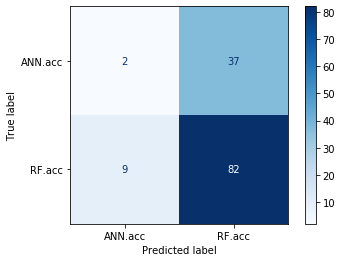


 

Fold  1  Id:  19
accuracy: 0.4076923076923077
precision:  0.6093180635085893
recall:  0.5583333333333333
f1_score:  0.38855292895974586
precision_recall_fscore_support : 
	
	[0.33628319 0.88235294]
	[0.95       0.16666667]
	[0.49673203 0.28037383]
	[40 90]


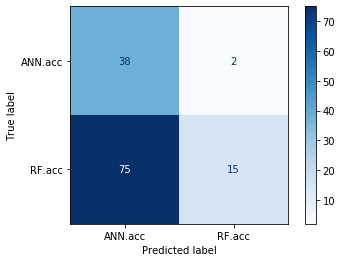


 

Fold  2  Id:  20
accuracy: 0.6976744186046512
precision:  0.3488372093023256
recall:  0.5
f1_score:  0.4109589041095891
precision_recall_fscore_support : 
	
	[0.         0.69767442]
	[0. 1.]
	[0.         0.82191781]
	[39 90]


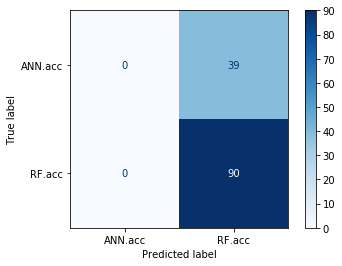


 

Mean accuracy =  0.5838401908169351 

-----------------------

Considered classes
SVM.acc -> 225
ANN.acc -> 170


Fold  0  Id:  21
accuracy: 0.5681818181818182
precision:  0.2840909090909091
recall:  0.5
f1_score:  0.36231884057971014
precision_recall_fscore_support : 
	
	[0.         0.56818182]
	[0. 1.]
	[0.         0.72463768]
	[57 75]


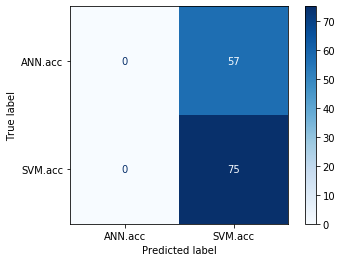


 

Fold  1  Id:  22
accuracy: 0.4015151515151515
precision:  0.3549180327868853
recall:  0.45859649122807017
f1_score:  0.31462372658560633
precision_recall_fscore_support : 
	
	[0.40983607 0.3       ]
	[0.87719298 0.04      ]
	[0.55865922 0.07058824]
	[57 75]


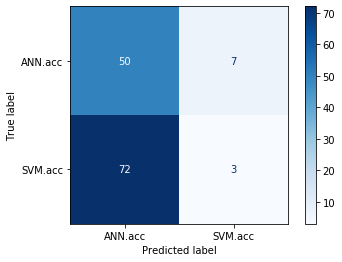


 

Fold  2  Id:  23
accuracy: 0.42748091603053434
precision:  0.21374045801526717
recall:  0.5
f1_score:  0.2994652406417112
precision_recall_fscore_support : 
	
	[0.42748092 0.        ]
	[1. 0.]
	[0.59893048 0.        ]
	[56 75]


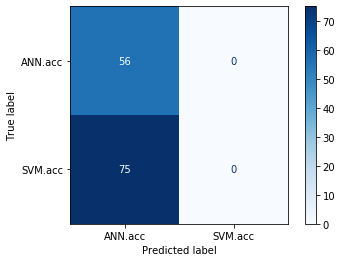


 

Mean accuracy =  0.46572596190916804 

-----------------------

Considered classes
ANN.acc -> 214
C4.5.acc -> 178


Fold  0  Id:  24
accuracy: 0.48854961832061067
precision:  0.5660919540229885
recall:  0.5270715630885122
f1_score:  0.42351395730706076
precision_recall_fscore_support : 
	
	[0.66666667 0.46551724]
	[0.13888889 0.91525424]
	[0.22988506 0.61714286]
	[72 59]


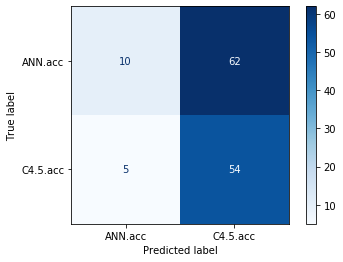


 

Fold  1  Id:  25
accuracy: 0.4580152671755725
precision:  0.22900763358778625
recall:  0.5
f1_score:  0.31413612565445026
precision_recall_fscore_support : 
	
	[0.         0.45801527]
	[0. 1.]
	[0.         0.62827225]
	[71 60]


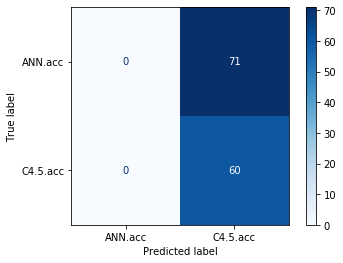


 

Fold  2  Id:  26
accuracy: 0.5307692307692308
precision:  0.5048076923076923
recall:  0.5031033659584627
f1_score:  0.4668907563025211
precision_recall_fscore_support : 
	
	[0.54807692 0.46153846]
	[0.8028169  0.20338983]
	[0.65142857 0.28235294]
	[71 59]


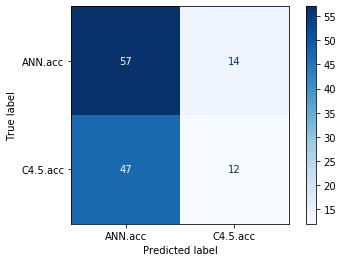


 

Mean accuracy =  0.4924447054218047 

-----------------------

Considered classes
kNN.acc -> 82
ANN.acc -> 313


Fold  0  Id:  27
accuracy: 0.5378787878787878
precision:  0.5422502870264064
recall:  0.5631868131868132
f1_score:  0.4984739956399876
precision_recall_fscore_support : 
	
	[0.83076923 0.25373134]
	[0.51923077 0.60714286]
	[0.63905325 0.35789474]
	[104  28]


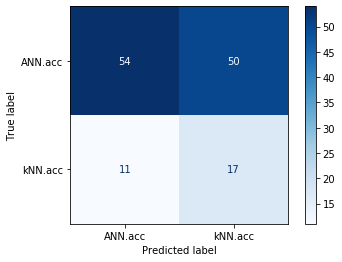


 

Fold  1  Id:  28
accuracy: 0.7954545454545454
precision:  0.3977272727272727
recall:  0.5
f1_score:  0.4430379746835443
precision_recall_fscore_support : 
	
	[0.79545455 0.        ]
	[1. 0.]
	[0.88607595 0.        ]
	[105  27]


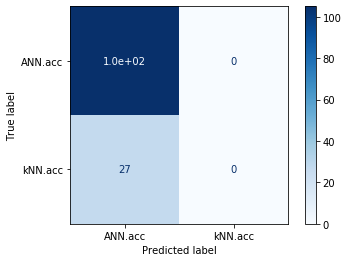


 

Fold  2  Id:  29
accuracy: 0.7251908396946565
precision:  0.5167698658410733
recall:  0.5115740740740741
f1_score:  0.5083402835696414
precision_recall_fscore_support : 
	
	[0.79824561 0.23529412]
	[0.875      0.14814815]
	[0.83486239 0.18181818]
	[104  27]


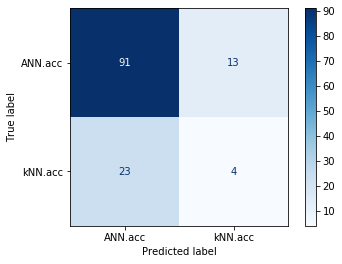


 

Mean accuracy =  0.6861747243426631 

-----------------------



In [13]:
from sklearn.metrics import precision_recall_fscore_support
reload(aux)
comb_to_drop = list(combinations(ALL_ACC, r=3))
raw = pd.read_csv('meta-base.csv')

features_list = []
acc_mean_list = []
#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas
# (retira os empates e seta as classes)
# divide o data em features e rótulo e divide os folds
iii = 0
for to_drop in comb_to_drop:
    data = raw.drop(list(to_drop), axis=1)
    considered_classes = ALL_ACC_SET - set(to_drop)
    data = preprocess_default(data, list(considered_classes))
    rfc = RandomForestClassifier(n_estimators=200)
    X = data.drop('Class', axis=1)
    y = data['Class']
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits)
    acc_list = []
    print("Considered classes")
    print_counter(y)
    print("\n")
    
    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        print("Fold ", k, " Id: ", iii)
        iii += 1
        rfc.fit(StandardScaler().fit_transform(X.loc[train_index, :]), y.loc[train_index])
        features_list.append(rfc.feature_importances_)
        y_pred = rfc.predict(X.loc[test_index, :], )
        
        acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))
        
        aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
        
        #matriz de confusão
        disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
        plt.show()
        print("\n \n")

    print("Mean accuracy = ", np.mean(acc_list) , "\n")
    acc_mean_list.append(np.mean(acc_list))
    print("-----------------------\n")
 
    

25 é das mais balanceadas (ANN x C4.5)


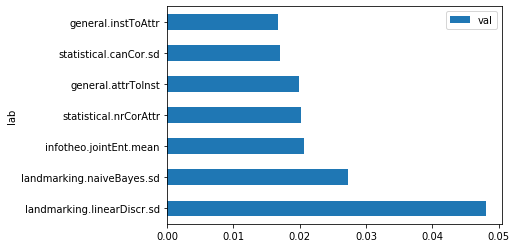

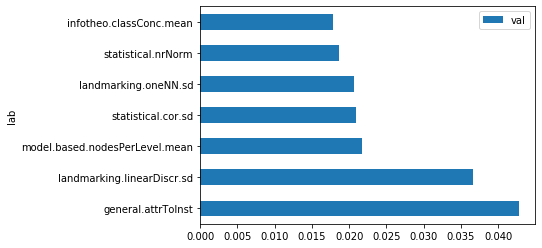

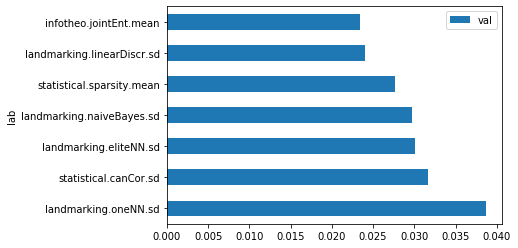

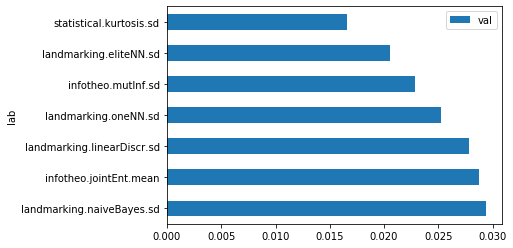

In [15]:
best_matrix = [7, 8, 24, 25]

show_most_important_features(
    X, map(lambda x: features_list[x], best_matrix)
)

print("25 é das mais balanceadas (ANN x C4.5)")

14 é das mais DESBALANCEADAS (ANN x C4.5)


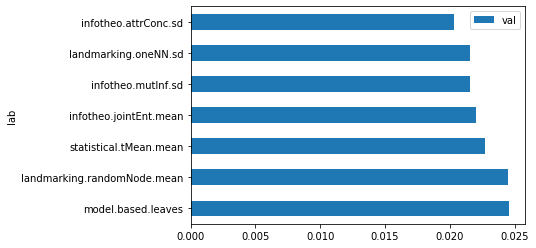

In [10]:
worst_matrix = [14]

show_most_important_features(
    X, map(lambda x: features_list[x], worst_matrix)
)
print("14 é das mais DESBALANCEADAS (ANN x C4.5)")

# Terceiro experimento - Random Forest x Outros

Considered classes
RF.acc -> 162
Other -> 221


Fold  0  Id:  0
accuracy: 0.4675324675324675
precision:  0.48071528751753156
recall:  0.4810606060606061
f1_score:  0.46717299578059074
precision_recall_fscore_support : 
	
	[0.5483871  0.41304348]
	[0.38636364 0.57575758]
	[0.45333333 0.48101266]
	[44 33]


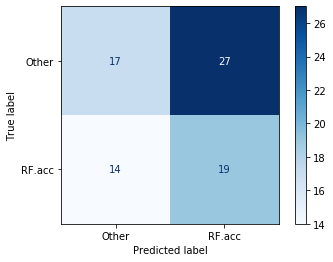


 

Fold  1  Id:  1
accuracy: 0.37662337662337664
precision:  0.38421052631578945
recall:  0.40909090909090906
f1_score:  0.3583333333333334
precision_recall_fscore_support : 
	
	[0.4        0.36842105]
	[0.18181818 0.63636364]
	[0.25       0.46666667]
	[44 33]


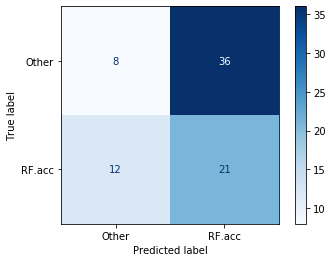


 

Fold  2  Id:  2
accuracy: 0.4155844155844156
precision:  0.2077922077922078
recall:  0.5
f1_score:  0.29357798165137616
precision_recall_fscore_support : 
	
	[0.         0.41558442]
	[0. 1.]
	[0.         0.58715596]
	[45 32]


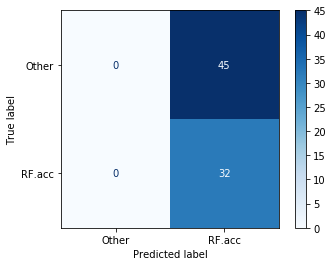


 

Fold  3  Id:  3
accuracy: 0.42105263157894735
precision:  0.21052631578947367
recall:  0.5
f1_score:  0.2962962962962963
precision_recall_fscore_support : 
	
	[0.         0.42105263]
	[0. 1.]
	[0.         0.59259259]
	[44 32]


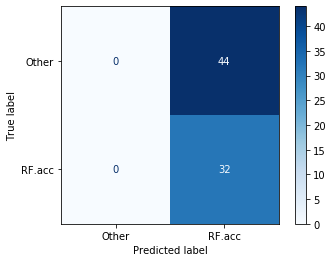


 

Fold  4  Id:  4
accuracy: 0.47368421052631576
precision:  0.4777777777777778
recall:  0.4772727272727273
f1_score:  0.4722222222222222
precision_recall_fscore_support : 
	
	[0.55555556 0.4       ]
	[0.45454545 0.5       ]
	[0.5        0.44444444]
	[44 32]


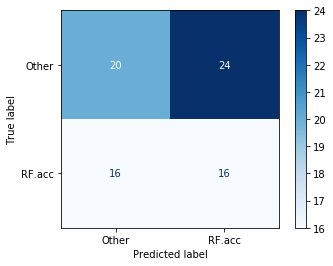


 

Mean accuracy =  0.4308954203691046 

-----------------------



In [17]:
data_rf_all = drop_all_vs_rf(pd.read_csv('meta-base.csv'))
data_rf_all.drop(data_rf_all.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)

#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas (retira os empates e seta as classes)
#divide o data em features e rótulo e divide os folds
data = data_rf_all
rfc = RandomForestClassifier(n_estimators=1000)
X = data.drop('Class', axis=1)
y = data['Class']
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=42,
                      shuffle=True)
acc_list = []
print("Considered classes")
print_counter(y)
print("\n")
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold ", k, " Id: ", iii)
    iii += 1    
    rfc.fit(StandardScaler().fit_transform(X.loc[train_index, :]), y.loc[train_index])
    features_list.append(rfc.feature_importances_)
    y_pred = rfc.predict(X.loc[test_index, :], )
    
    acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))

    aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    
    #matriz de confusão
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                             display_labels=None,
                             cmap=plt.cm.Blues,
                             normalize=None)
    plt.show()
    print("\n \n")

print("Mean accuracy = ", np.mean(acc_list), "\n")
print("-----------------------\n")


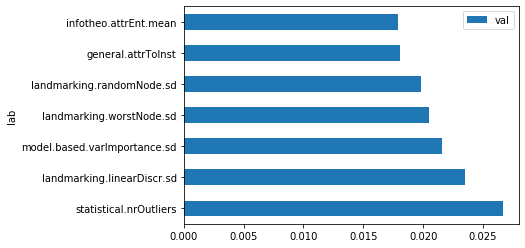

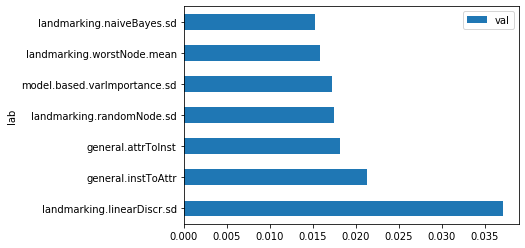

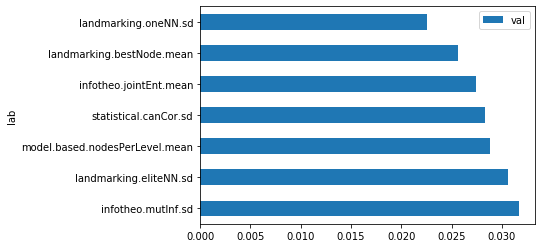

In [12]:
matrix = [1, 2, 3]

show_most_important_features(
    X, map(lambda x: features_list[x], matrix)
)